# Simple Hierarchical Model using PyStan
## The Red Clump

We will make a data set that broadly represents a clean red clump sample of stars.  There will some intrinsic width in the sample and there will be measurement uncertainty.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pystan
import seaborn as sns

Let's make the data first and examine it.

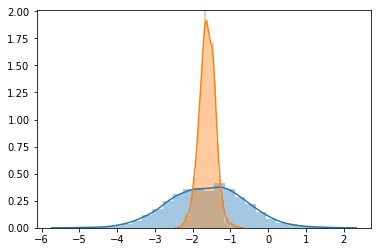

In [2]:
npts = 1000
sigma = 0.2
mean = -1.61
M_true = np.random.randn(npts) * sigma + mean
unc = 1.0
M = M_true + np.random.randn(npts) * unc
sns.distplot(M)
sns.distplot(M_true)

Now we have to cope with the STAN model.

In [5]:
clump_model = '''
data {
    int<lower=0> N;
    real M[N];
    real<lower = 0> tau;
}
parameters {
    real mu;
    real<lower =0.001> sigma;
    real M_true_std[N];
}
transformed parameters {
    real M_true[N]; // Transform from N(0,1) back to M
    for (i in 1:N)
        M_true[i] = mu + sigma * M_true_std[i];
}
model {
    M_true_std ~ normal(0, 1); // prior but transformed
    M ~ normal(M_true, tau); // Measurement uncertainty
}
'''
sm = pystan.StanModel(model_code=clump_model, model_name='ClumpModel')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL ClumpModel_86ff5c787ba1b231b4f294f94e86f2bc NOW.


Now we run the sampler.  This is expected to make the sampler work hard!  We therfore increase then number iter and take care to look at the rhat statistic.

/usr/local/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


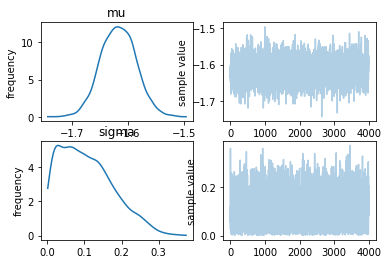

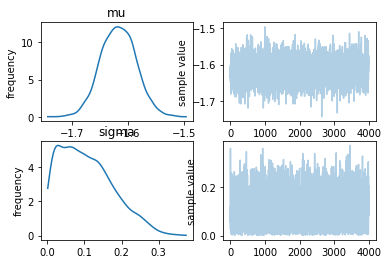

In [6]:
dat = {'N': len(M),
      'M': M,
      'tau': unc}
fit = sm.sampling(data=dat, iter=2000, chains=4, pars=['mu', 'sigma'])
fit.plot()

In [7]:
print(fit)

Inference for Stan model: ClumpModel_86ff5c787ba1b231b4f294f94e86f2bc.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu     -1.62  4.9e-4   0.03  -1.68  -1.64  -1.62   -1.6  -1.56   4000    1.0
sigma   0.11  2.8e-3   0.07 5.9e-3   0.05    0.1   0.15   0.26    672    1.0
lp__  -981.9    0.72  23.65  -1028 -997.6 -982.1 -966.1 -934.4   1077    1.0

Samples were drawn using NUTS at Fri Feb 16 08:21:45 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
